In [46]:

#mount drive
from google.colab import drive
drive.mount('/content/MyDrive')
import seaborn as sns
sns.set_theme("paper")

Drive already mounted at /content/MyDrive; to attempt to forcibly remount, call drive.mount("/content/MyDrive", force_remount=True).


In [47]:
import os
import torch
import joblib
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from scipy.io import wavfile
from sklearn.metrics import mean_squared_error
import statistics
from scipy.signal import savgol_filter, butter, filtfilt

class Config:
    def __init__(self, **kwargs):
        self.batch_size = kwargs.get('batch_size', 64)
        self.epochs = kwargs.get('epochs', 50)
        self.lr = kwargs.get('lr', 0.001)
        self.channels_imu_acc = kwargs.get('channels_imu_acc', [])
        self.channels_imu_acc_test = kwargs.get('channels_imu_acc_test', [])
        self.channels_imu_gyr_test = kwargs.get('channels_imu_gyr_test', [])
        self.channels_imu_gyr = kwargs.get('channels_imu_gyr', [])
        self.channels_joints = kwargs.get('channels_joints', [])
        self.channels_emg = kwargs.get('channels_emg', [])
        self.seed = kwargs.get('seed', 42)
        self.data_folder_name = kwargs.get('data_folder_name', 'default_data_folder_name')
        self.dataset_root = kwargs.get('dataset_root', 'default_dataset_root')
        self.dataset_train_name = kwargs.get('dataset_train_name', 'train')
        self.dataset_test_name = kwargs.get('dataset_test_name', 'test')
        self.window_length = kwargs.get('window_length', 100)
        self.window_overlap = kwargs.get('window_overlap', 0)
        self.imu_transforms = kwargs.get('imu_transforms', [])
        self.joint_transforms = kwargs.get('joint_transforms', [])
        self.emg_transforms = kwargs.get('emg_transforms', [])
        self.input_format = kwargs.get('input_format', 'csv')
        self.train_subjects = kwargs.get('train_subjects', [])
        self.test_subjects = kwargs.get('test_subjects', [])

        self.dataset_name = self.generate_dataset_name()

    def generate_dataset_name(self):
        name = f"dataset_wl{self.window_length}_ol{self.window_overlap}_train{self.train_subjects}_test{self.test_subjects}"
        return name

In [48]:
class ImuJointPairDataset(Dataset):
    def __init__(self, config, split='train'):
        self.config = config
        self.split = split
        self.input_format = config.input_format
        self.channels_imu_acc = config.channels_imu_acc
        self.channels_imu_acc_test = config.channels_imu_acc_test
        self.channels_imu_gyr = config.channels_imu_gyr
        self.channels_imu_gyr_test = config.channels_imu_gyr_test
        self.channels_joints = config.channels_joints
        self.channels_emg = config.channels_emg

        dataset_name = self.config.dataset_name
        self.root_dir_train = os.path.join(self.config.dataset_root, dataset_name, self.config.dataset_train_name)
        self.root_dir_test = os.path.join(self.config.dataset_root, dataset_name, self.config.dataset_test_name)

        train_info_path = os.path.join(self.config.dataset_root, dataset_name, "train_info.csv")
        test_info_path = os.path.join(self.config.dataset_root, dataset_name, "test_info.csv")
        self.data = pd.read_csv(train_info_path) if split == 'train' else pd.read_csv(test_info_path)

        self.scaler_save_path = os.path.join(self.config.dataset_root, dataset_name, "scaler.pkl")
        self.scaler = joblib.load(self.scaler_save_path) if os.path.exists(self.scaler_save_path) else None

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.split == "train":
            file_path = os.path.join(self.root_dir_train, self.data.iloc[idx, 0])
        else:
            file_path = os.path.join(self.root_dir_test, self.data.iloc[idx, 0])

        if self.input_format == "wav":
            combined_data, _ = get_data_from_wav_file(file_path)
        elif self.input_format == "csv":
            combined_data = pd.read_csv(file_path)
        else:
            raise ValueError("Unsupported input format: {}".format(self.input_format))

        imu_data_acc, imu_data_gyr, joint_data, emg_data = self._extract_and_transform(combined_data)
        windows = self._apply_windowing(imu_data_acc, imu_data_gyr, joint_data, emg_data, self.config.window_length, self.config.window_overlap)

        acc_concat = np.concatenate([w[0] for w in windows], axis=0)
        gyr_concat = np.concatenate([w[1] for w in windows], axis=0)
        joint_concat = np.concatenate([w[2] for w in windows], axis=0)
        emg_concat = np.concatenate([w[3] for w in windows], axis=0)

        return acc_concat, gyr_concat, joint_concat, emg_concat

    def _extract_and_transform(self, combined_data):
        imu_data_acc = self._extract_channels(combined_data, self.channels_imu_acc)
        imu_data_gyr = self._extract_channels(combined_data, self.channels_imu_gyr)
        joint_data = self._extract_channels(combined_data, self.channels_joints)
        emg_data = self._extract_channels(combined_data, self.channels_emg)

        combined_data = np.concatenate([imu_data_acc, imu_data_gyr, joint_data, emg_data], axis=1)
        scaled_data = combined_data

        imu_data_acc = scaled_data[:, :imu_data_acc.shape[1]]
        imu_data_gyr = scaled_data[:, imu_data_acc.shape[1]:imu_data_acc.shape[1] + imu_data_gyr.shape[1]]
        joint_data = scaled_data[:, imu_data_acc.shape[1] + imu_data_gyr.shape[1]:imu_data_acc.shape[1] + imu_data_gyr.shape[1] + joint_data.shape[1]]
        emg_data = scaled_data[:, imu_data_acc.shape[1] + imu_data_gyr.shape[1] + joint_data.shape[1]:]

        imu_data_acc = self.apply_transforms(imu_data_acc, self.config.imu_transforms)
        imu_data_gyr = self.apply_transforms(imu_data_gyr, self.config.imu_transforms)
        joint_data = self.apply_transforms(joint_data, self.config.joint_transforms)
        emg_data = self.apply_transforms(emg_data, self.config.emg_transforms)

        return imu_data_acc, imu_data_gyr, joint_data, emg_data

    def _extract_channels(self, combined_data, channels):
        if isinstance(channels, slice):
            return combined_data.iloc[:, channels].values if self.input_format == "csv" else combined_data[:, channels]
        else:
            return combined_data[channels].values if self.input_format == "csv" else combined_data[:, channels]

    def _apply_windowing(self, imu_data_acc, imu_data_gyr, joint_data, emg_data, window_length, window_overlap):
        num_samples = imu_data_acc.shape[0]
        step = window_length - window_overlap
        windows = []

        for start in range(0, num_samples - window_length + 1, step):
            end = start + window_length
            window = (
                imu_data_acc[start:end],
                imu_data_gyr[start:end],
                joint_data[start:end],
                emg_data[start:end]
            )
            windows.append(window)

        return windows

    def apply_transforms(self, data, transforms):
        for transform in transforms:
            data = transform(data)
        data = torch.tensor(data, dtype=torch.float32)
        return data


In [49]:
#prediction function
def RMSE_prediction(yhat_4,test_y, output_dim,print_losses=True):

  s1=yhat_4.shape[0]*yhat_4.shape[1]

  test_o=test_y.reshape((s1,output_dim))
  yhat=yhat_4.reshape((s1,output_dim))




  y_1_no=yhat[:,0]
  y_2_no=yhat[:,1]
  y_3_no=yhat[:,2]

  y_1=y_1_no
  y_2=y_2_no
  y_3=y_3_no


  y_test_1=test_o[:,0]
  y_test_2=test_o[:,1]
  y_test_3=test_o[:,2]



  cutoff=6
  fs=200
  order=4

  nyq = 0.5 * fs
  ## filtering data ##
  def butter_lowpass_filter(data, cutoff, fs, order):
      normal_cutoff = cutoff / nyq
      # Get the filter coefficients
      b, a = butter(order, normal_cutoff, btype='low', analog=False)
      y = filtfilt(b, a, data)
      return y



  Z_1=y_1
  Z_2=y_2
  Z_3=y_3



  ###calculate RMSE

  rmse_1 =((np.sqrt(mean_squared_error(y_test_1,y_1))))
  rmse_2 =((np.sqrt(mean_squared_error(y_test_2,y_2))))
  rmse_3 =((np.sqrt(mean_squared_error(y_test_3,y_3))))





  p_1=np.corrcoef(y_1, y_test_1)[0, 1]
  p_2=np.corrcoef(y_2, y_test_2)[0, 1]
  p_3=np.corrcoef(y_3, y_test_3)[0, 1]




              ### Correlation ###
  p=np.array([p_1,p_2,p_3])
  #,p_4,p_5,p_6,p_7])




      #### Mean and standard deviation ####

  rmse=np.array([rmse_1,rmse_2,rmse_3])
  #,rmse_4,rmse_5,rmse_6,rmse_7])

      #### Mean and standard deviation ####
  m=statistics.mean(rmse)
  SD=statistics.stdev(rmse)


  m_c=statistics.mean(p)
  SD_c=statistics.stdev(p)


  if print_losses:
    print(rmse_1)
    print(rmse_2)
    print(rmse_3)
    print("\n")
    print(p_1)
    print(p_2)
    print(p_3)
    print('Mean: %.3f' % m,'+/- %.3f' %SD)
    print('Mean: %.3f' % m_c,'+/- %.3f' %SD_c)

  return rmse, p, Z_1,Z_2,Z_3
  #,Z_4,Z_5,Z_6,Z_7



############################################################################################################################################################################################################################################################################################################################################################################################################################################################################


In [50]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
class Encoder_1(nn.Module):
    def __init__(self, input_dim, dropout):
        super(Encoder_1, self).__init__()
        self.lstm_1 = nn.LSTM(input_dim, 128, bidirectional=True, batch_first=True, dropout=0.0)
        self.lstm_2 = nn.LSTM(256, 64, bidirectional=True, batch_first=True, dropout=0.0)
        self.flatten=nn.Flatten()
        self.fc = nn.Linear(128, 32)
        self.dropout_1=nn.Dropout(dropout)
        self.dropout_2=nn.Dropout(dropout)


    def forward(self, x):
        out_1, _ = self.lstm_1(x)
        out_1=self.dropout_1(out_1)
        out_2, _ = self.lstm_2(out_1)
        out_2=self.dropout_2(out_2)

        return out_2




class Encoder_2(nn.Module):
    def __init__(self, input_dim, dropout):
        super(Encoder_2, self).__init__()
        self.lstm_1 = nn.GRU(input_dim, 128, bidirectional=True, batch_first=True, dropout=0.0)
        self.lstm_2 = nn.GRU(256, 64, bidirectional=True, batch_first=True, dropout=0.0)
        self.flatten=nn.Flatten()
        self.fc = nn.Linear(128, 32)
        self.dropout_1=nn.Dropout(dropout)
        self.dropout_2=nn.Dropout(dropout)


    def forward(self, x):
        out_1, _ = self.lstm_1(x)
        out_1=self.dropout_1(out_1)
        out_2, _ = self.lstm_2(out_1)
        out_2=self.dropout_2(out_2)

        return out_2


class GatingModule(nn.Module):
    def __init__(self, input_size):
        super(GatingModule, self).__init__()
        self.gate = nn.Sequential(
            nn.Linear(2*input_size, input_size),
            nn.Sigmoid()
        )

    def forward(self, input1, input2):
        # Apply gating mechanism
        gate_output = self.gate(torch.cat((input1,input2),dim=-1))

        # Scale the inputs based on the gate output
        gated_input1 = input1 * gate_output
        gated_input2 = input2 * (1 - gate_output)

        # Combine the gated inputs
        output = gated_input1 + gated_input2
        return output
#variable w needs to be checked for correct value, stand-in value used
class teacher(nn.Module):
    def __init__(self, input_acc, input_gyr, input_emg, drop_prob=0.25, w=100):
        super(teacher, self).__init__()

        self.w=w
        self.encoder_1_acc=Encoder_1(input_acc, drop_prob)
        self.encoder_1_gyr=Encoder_1(input_gyr, drop_prob)
        self.encoder_1_emg=Encoder_1(input_emg, drop_prob)

        self.encoder_2_acc=Encoder_2(input_acc, drop_prob)
        self.encoder_2_gyr=Encoder_2(input_gyr, drop_prob)
        self.encoder_2_emg=Encoder_2(input_emg, drop_prob)

        self.BN_acc= nn.BatchNorm1d(input_acc, affine=False)
        self.BN_gyr= nn.BatchNorm1d(input_gyr, affine=False)
        self.BN_emg= nn.BatchNorm1d(input_emg, affine=False)


        self.fc = nn.Linear(2*3*128+128,3)
        self.dropout=nn.Dropout(p=0.05)

        self.gate_1=GatingModule(128)
        self.gate_2=GatingModule(128)
        self.gate_3=GatingModule(128)

        self.fc_kd = nn.Linear(3*128, 2*128)

               # Define the gating network
        self.weighted_feat = nn.Sequential(
            nn.Linear(128, 1),
            nn.Sigmoid())

        self.attention=nn.MultiheadAttention(3*128,4,batch_first=True)
        self.gating_net = nn.Sequential(nn.Linear(128*3, 3*128), nn.Sigmoid())
        self.gating_net_1 = nn.Sequential(nn.Linear(2*3*128+128, 2*3*128+128), nn.Sigmoid())

        self.pool = nn.MaxPool1d(kernel_size=2)


    def forward(self, x_acc, x_gyr, x_emg):

        x_acc_1=x_acc.view(x_acc.size(0)*x_acc.size(1),x_acc.size(-1))
        x_gyr_1=x_gyr.view(x_gyr.size(0)*x_gyr.size(1),x_gyr.size(-1))
        x_emg_1=x_emg.view(x_emg.size(0)*x_emg.size(1),x_emg.size(-1))

        x_acc_1=self.BN_acc(x_acc_1)
        x_gyr_1=self.BN_gyr(x_gyr_1)
        x_emg_1=self.BN_emg(x_emg_1)

        x_acc_2=x_acc_1.view(-1, self.w, x_acc_1.size(-1))
        x_gyr_2=x_gyr_1.view(-1, self.w, x_gyr_1.size(-1))
        x_emg_2=x_emg_1.view(-1, self.w, x_emg_1.size(-1))

        x_acc_1=self.encoder_1_acc(x_acc_2)
        x_gyr_1=self.encoder_1_gyr(x_gyr_2)
        x_emg_1=self.encoder_1_emg(x_emg_2)

        x_acc_2=self.encoder_2_acc(x_acc_2)
        x_gyr_2=self.encoder_2_gyr(x_gyr_2)
        x_emg_2=self.encoder_2_emg(x_emg_2)

        # x_acc=torch.cat((x_acc_1,x_acc_2),dim=-1)
        # x_gyr=torch.cat((x_gyr_1,x_gyr_2),dim=-1)
        # x_emg=torch.cat((x_emg_1,x_emg_2),dim=-1)

        x_acc=self.gate_1(x_acc_1,x_acc_2)
        x_gyr=self.gate_2(x_gyr_1,x_gyr_2)
        x_emg=self.gate_3(x_emg_1,x_emg_2)

        x=torch.cat((x_acc,x_gyr,x_emg),dim=-1)
        x_kd=self.fc_kd(x)


        out_1, attn_output_weights=self.attention(x,x,x)

        gating_weights = self.gating_net(x)
        out_2=gating_weights*x

        weights_1 = self.weighted_feat(x[:,:,0:128])
        weights_2 = self.weighted_feat(x[:,:,128:2*128])
        weights_3 = self.weighted_feat(x[:,:,2*128:3*128])
        x_1=weights_1*x[:,:,0:128]
        x_2=weights_2*x[:,:,128:2*128]
        x_3=weights_3*x[:,:,2*128:3*128]
        out_3=x_1+x_2+x_3

        out=torch.cat((out_1,out_2,out_3),dim=-1)

        gating_weights_1 = self.gating_net_1(out)
        out=gating_weights_1*out

        out=self.fc(out)

        #print(out.shape)
        return out,x_kd


class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
    def forward(self, output, target):
        loss = torch.sqrt(torch.mean((output - target) ** 2))
        return loss




In [51]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import time
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from scipy.signal import butter, filtfilt
import statistics

# Save checkpoint function
def save_checkpoint(model, optimizer, epoch, filename, train_loss, val_loss, test_loss=None, channelwise_metrics=None):
    """Saves the model, optimizer state, and losses (including channel-wise) to a checkpoint."""
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_loss,
        'val_loss': val_loss,
        'train_channelwise_metrics': channelwise_metrics['train'],
        'val_channelwise_metrics': channelwise_metrics['val'],
    }
    if test_loss is not None:
        checkpoint['test_loss'] = test_loss
        checkpoint['test_channelwise_metrics'] = channelwise_metrics['test']



    torch.save(checkpoint, filename)
    print(f"Checkpoint saved for epoch {epoch + 1}")

# Evaluation function
def evaluate_model(device, model, loader, criterion):
    """Runs evaluation on the validation or test set."""
    model.eval()
    total_loss = 0.0
    total_pcc = np.zeros(len(config.channels_joints))
    total_rmse = np.zeros(len(config.channels_joints))

    with torch.no_grad():
        for i, (data_acc, data_gyr, target, data_EMG) in enumerate(loader):
            output, _ = model(data_acc.to(device).float(), data_gyr.to(device).float(), data_EMG.to(device).float())
            loss = criterion(output, target.to(device).float())
            batch_rmse, batch_pcc, _, _, _ = RMSE_prediction(output.detach().cpu().numpy(), target.detach().cpu().numpy(), len(config.channels_joints), print_losses=False)
            total_loss += loss.item()
            total_pcc += batch_pcc
            total_rmse += batch_rmse

    avg_loss = total_loss / len(loader)
    avg_pcc = total_pcc / len(loader)
    avg_rmse = total_rmse / len(loader)

    return avg_loss, avg_pcc, avg_rmse

# Training function
def train_teacher(device, train_loader, val_loader, test_loader, learn_rate, epochs, model, filename):
    if torch.cuda.is_available():
        model.cuda()

    criterion = RMSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

    train_losses = []
    val_losses = []
    test_losses = []

    train_pccs = []
    val_pccs = []
    test_pccs = []

    train_rmses = []
    val_rmses = []
    test_rmses = []

    start_time = time.time()
    best_val_loss = float('inf')
    patience = 20
    patience_counter = 0

    for epoch in range(epochs):
        epoch_start_time = time.time()
        model.train()

        epoch_train_loss = np.zeros(len(config.channels_joints))
        epoch_train_pcc = np.zeros(len(config.channels_joints))
        epoch_train_rmse = np.zeros(len(config.channels_joints))

        for i, (data_acc, data_gyr, target, data_EMG) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs} Training")):
            optimizer.zero_grad()
            output, _ = model(data_acc.to(device).float(), data_gyr.to(device).float(), data_EMG.to(device).float())
            loss = criterion(output, target.to(device).float())
            loss.backward()
            optimizer.step()

            batch_rmse, batch_pcc, _, _, _ = RMSE_prediction(output.detach().cpu().numpy(), target.detach().cpu().numpy(), len(config.channels_joints), print_losses=False)
            epoch_train_loss += loss.detach().cpu().numpy()
            epoch_train_pcc += batch_pcc
            epoch_train_rmse += batch_rmse

        avg_train_loss = epoch_train_loss / len(train_loader)
        avg_train_pcc = epoch_train_pcc / len(train_loader)
        avg_train_rmse = epoch_train_rmse / len(train_loader)

        train_losses.append(avg_train_loss)
        train_pccs.append(avg_train_pcc)
        train_rmses.append(avg_train_rmse)

        # Evaluate on validation set every epoch
        avg_val_loss, avg_val_pcc, avg_val_rmse = evaluate_model(device, model, val_loader, criterion)
        val_losses.append(avg_val_loss)
        val_pccs.append(avg_val_pcc)
        val_rmses.append(avg_val_rmse)


        # Evaluate on test set and checkpoint every epoch
        avg_test_loss, avg_test_pcc, avg_test_rmse = evaluate_model(device, model, test_loader, criterion)
        test_losses.append(avg_test_loss)
        test_pccs.append(avg_test_pcc)
        test_rmses.append(avg_test_rmse)

        print(f"Epoch: {epoch + 1}, Training Loss: {np.mean(avg_train_loss)}, Validation Loss: {np.mean(avg_val_loss):.4f}", f"Test Loss: {np.mean(avg_test_loss):.4f}")
        print(f"Training PCC: {np.mean(avg_train_pcc)}, Validation PCC: {np.mean(avg_val_pcc):.4f}", f"Test PCC: {np.mean(avg_test_pcc):.4f}")


        if not os.path.exists(f"/content/MyDrive/MyDrive/models/{filename}"):
          os.makedirs(f"/content/MyDrive/MyDrive/models/{filename}")

        # Save checkpoint, including channel-wise metrics
        save_checkpoint(
            model,
            optimizer,
            epoch,
            f"/content/MyDrive/MyDrive/models/{filename}/{filename}_epoch_{epoch+1}.pth",
            train_loss=avg_train_loss,
            val_loss=avg_val_loss,
            test_loss=avg_test_loss,
            channelwise_metrics={
                'train': {'pcc': avg_train_pcc, 'rmse': avg_train_rmse},
                'val': {'pcc': avg_val_pcc, 'rmse': avg_val_rmse},
                'test': {'pcc': avg_test_pcc, 'rmse': avg_test_rmse},
            }
        )

        # Early stopping logic
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), filename)
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Stopping early after {epoch + 1} epochs")
            break

    end_time = time.time()
    print(f"Total training time: {end_time - start_time:.2f} seconds")

    return model, train_losses, val_losses, test_losses, train_pccs, val_pccs, test_pccs, train_rmses, val_rmses, test_rmses


In [52]:
class DataSharder:
    def __init__(self, config, save_h5=False):
        self.config = config
        self.input_format = config.input_format
        self.data_folder_path = config.data_folder_name
        self.window_length = int(config.window_length)
        self.window_overlap = int(config.window_overlap)
        self.save_h5 = save_h5

    def load_data(self):
        print(f"Training subjects: {self.config.train_subjects}")
        print(f"Testing subjects: {self.config.test_subjects}")

        if self.input_format == 'wav':
            self._process_and_save_patients_wav(self.config.train_subjects, "train")
            self._process_and_save_patients_wav(self.config.test_subjects, "test")
        elif self.input_format == 'csv':
            self._process_and_save_patients_csv(self.config.train_subjects, "train")
            self._process_and_save_patients_csv(self.config.test_subjects, "test")
        else:
            raise ValueError(f"Unsupported input format: {self.input_format}")

    def _process_and_save_patients_wav(self, patient_id_list, split):
        total_data = []
        for patient_id in tqdm(patient_id_list, desc=f"Processing {split} patients"):
            for session_index in tqdm(range(len(self.config.train_subjects)), desc=f"Processing sessions for {patient_id}", leave=False):
                imu_data, imu_sample_rate = self._load_wav_file(patient_id, session_index, "IMU")
                joints_data, joints_sample_rate = self._load_wav_file(patient_id, session_index, "JOINTS")
                emg_data, emg_sample_rate = self._load_wav_file(patient_id, session_index, "EMG")

                imu_data = self._resample_data(imu_data, imu_sample_rate)
                joints_data = self._resample_data(joints_data, joints_sample_rate)
                emg_data = self._resample_data(emg_data, emg_sample_rate)

                combined_data = torch.cat((imu_data, joints_data, emg_data), dim=1)
                total_data.append(combined_data.cpu().numpy())

        if self.save_h5:
            self._save_to_h5(total_data, split)
        else:
            for combined_data in total_data:
                self._save_windowed_data(combined_data, patient_id, session_index, split)

    def _load_wav_file(self, patient_id, session_index, file_type):
        file_path = os.path.join(self.data_folder_path, patient_id, f"run{session_index}_{file_type}.wav")
        data, sample_rate = get_data_from_wav_file(file_path)
        return torch.tensor(data, dtype=torch.float32), sample_rate

    def _resample_data(self, data, sample_rate):
        if sample_rate != self.sample_rate:
            data = torch.nn.functional.interpolate(data.unsqueeze(0), size=self.sample_rate, mode='linear').squeeze(0)
        return data

    def _process_and_save_patients_csv(self, patient_id_list, split):
        column_names = None
        for patient_id in tqdm(patient_id_list, desc=f"Processing {split} patients"):
            combined_path = os.path.join(self.data_folder_path, patient_id, "combined")
            if not os.path.exists(combined_path):
                print(f"Directory {combined_path} does not exist. Skipping patient {patient_id}.")
                continue

            patient_files = os.listdir(combined_path)
            for session_file in tqdm(patient_files, desc=f"Processing sessions for {patient_id}", leave=False):
                data = pd.read_csv(os.path.join(combined_path, session_file))
                if column_names is None:
                    column_names = data.columns.tolist()  # Convert Index to list
                data_np = data.to_numpy()
                # Pad array to fit columns if necessary
                if data_np.shape[1] < len(column_names):
                    data_np = np.pad(data_np, ((0, 0), (0, len(column_names) - data_np.shape[1])), mode='constant')
                elif data_np.shape[1] > len(column_names):
                    # Extend column names to match the data shape
                    extra_columns = [f"extra_{i}" for i in range(data_np.shape[1] - len(column_names))]
                    column_names.extend(extra_columns)

                self._save_windowed_data(pd.DataFrame(data_np, columns=column_names), patient_id, session_file.split('.')[0], split, is_csv=True)

    def _save_windowed_data(self, data, patient_id, session_id, split, is_csv=False):
        dataset_folder = os.path.join(self.config.dataset_root, self.config.dataset_name, self.config.dataset_train_name if split == "train" else self.config.dataset_test_name)
        os.makedirs(dataset_folder, exist_ok=True)

        window_size = self.window_length
        overlap = self.window_overlap
        step_size = window_size - overlap

        data_info_list = []

        for i in tqdm(range(0, len(data) - window_size + 1, step_size), desc=f"Windowing data for {patient_id}_{session_id}", leave=False):
            windowed_data = data.iloc[i:i+window_size] if is_csv else data[i:i+window_size]
            if windowed_data.shape[0] < window_size:
                continue

            windowed_data_np = windowed_data.to_numpy() if is_csv else windowed_data.cpu().numpy()

            file_name = f"{patient_id}_session_{session_id}_window_{i}_ws{window_size}_ol{overlap}.csv"
            file_path = os.path.join(dataset_folder, file_name)
            pd.DataFrame(windowed_data_np, columns=data.columns if is_csv else None).to_csv(file_path, index=False)
            data_info_list.append({"file_name": file_name, "file_path": file_path})

        data_info_df = pd.DataFrame(data_info_list)
        data_info_df.to_csv(os.path.join(self.config.dataset_root, self.config.dataset_name, f"{split}_info.csv"), index=False, mode='a', header=not os.path.exists(os.path.join(self.config.dataset_root, self.config.dataset_name, f"{split}_info.csv")))


In [53]:
import shutil
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = Config(
    data_folder_name='/content/MyDrive/MyDrive/sd_datacollection',
    dataset_root='/content/datasets',
    dataset_train_name='train',
    dataset_test_name='test',
    batch_size=64,
    epochs=150,
    lr=0.001,
    window_length=100,
    window_overlap=75,
    input_format="csv",
    channels_imu_acc=['ACCX1', 'ACCY1', 'ACCZ1', 'ACCX2', 'ACCY2', 'ACCZ2', 'ACCX3', 'ACCY3', 'ACCZ3', 'ACCX4', 'ACCY4', 'ACCZ4', 'ACCX5', 'ACCY5', 'ACCZ5', 'ACCX6', 'ACCY6', 'ACCZ6'],
    channels_imu_acc_test=['ACCX1', 'ACCY1', 'ACCZ1', 'ACCX2', 'ACCY2', 'ACCZ2', 'ACCX3', 'ACCY3', 'ACCZ3', 'ACCX4', 'ACCY4', 'ACCZ4', 'ACCX5', 'ACCY5', 'ACCZ5', 'ACCX6', 'ACCY6', 'ACCZ6'],
    channels_imu_gyr=['GYROX1', 'GYROY1', 'GYROZ1', 'GYROX2', 'GYROY2', 'GYROZ2', 'GYROX3', 'GYROY3', 'GYROZ3', 'GYROX4', 'GYROY4', 'GYROZ4', 'GYROX5', 'GYROY5', 'GYROZ5', 'GYROX6', 'GYROY6', 'GYROZ6'],
    channels_imu_gyr_test=['GYROX1', 'GYROY1', 'GYROZ1', 'GYROX2', 'GYROY2', 'GYROZ2', 'GYROX3', 'GYROY3', 'GYROZ3', 'GYROX4', 'GYROY4', 'GYROZ4', 'GYROX5', 'GYROY5', 'GYROZ5', 'GYROX6', 'GYROY6', 'GYROZ6'],
    channels_joints=['elbow_flex_r', 'arm_flex_r', 'arm_add_r'],
    channels_emg=['IM EMG4', 'IM EMG5', 'IM EMG6'],
    train_subjects=['subject_2','subject_3','subject_4','subject_5','subject_6','subject_7','subject_8', 'subject_9','subject_10', 'subject_11','subject_12','subject_13'],
    test_subjects=['subject_1']
)





In [54]:
reshard = False

if reshard:
  data_sharder = DataSharder(config)
  data_sharder.load_data()

  #copy new dataset to drive
  # shutil.copytree(os.path.join("/content/datasets",config.dataset_name),os.path.join("/content/MyDrive/MyDrive/datasets",config.dataset_name))

if not os.path.exists("/content/datasets"):
    #copy over
    shutil.copytree(os.path.join("/content/MyDrive/MyDrive/datasets",config.dataset_name),os.path.join("/content/datasets",config.dataset_name))



In [55]:
# Create datasets
train_dataset = ImuJointPairDataset(config, split='train')
test_dataset = ImuJointPairDataset(config, split='test')

# Setup validation dataset
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [int(0.9 * len(train_dataset)), len(train_dataset) - int(0.9 * len(train_dataset))])

# Setup dataloaders
train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)

# Train the model
model = teacher(
    input_acc=len(config.channels_imu_acc),
    input_gyr=len(config.channels_imu_gyr),
    input_emg=len(config.channels_emg)
)

In [56]:

acc,gyro,target,emg=next(iter(train_loader))
print(acc.shape)
print(gyro.shape)
print(target.shape)
print(emg.shape)

print(acc.dtype)
print(gyro.dtype)
print(target.dtype)
print(emg.dtype)


torch.Size([64, 100, 18])
torch.Size([64, 100, 18])
torch.Size([64, 100, 3])
torch.Size([64, 100, 3])
torch.float32
torch.float32
torch.float32
torch.float32


In [57]:
model = teacher(18, 18, 3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


#train teacher
model, train_losses, val_losses, test_losses, train_pccs, val_pccs, test_pccs, train_rmses, val_rmses, test_rmses = train_teacher(device,train_loader, val_loader, test_loader,config.lr, config.epochs, model, 'new_opensimmodel_first_run_all_subjects')

Epoch 1/150 Training: 100%|██████████| 327/327 [02:33<00:00,  2.13it/s]


Epoch: 1, Training Loss: 21.50580836071516, Validation Loss: 13.5433 Test Loss: 21.3560
Training PCC: 0.734042207172323, Validation PCC: 0.9196 Test PCC: 0.6407
Checkpoint saved for epoch 1


Epoch 2/150 Training: 100%|██████████| 327/327 [02:32<00:00,  2.15it/s]


Epoch: 2, Training Loss: 11.994659399038426, Validation Loss: 9.9784 Test Loss: 21.2326
Training PCC: 0.937212873725691, Validation PCC: 0.9593 Test PCC: 0.5627
Checkpoint saved for epoch 2


Epoch 3/150 Training: 100%|██████████| 327/327 [02:31<00:00,  2.16it/s]


Epoch: 3, Training Loss: 10.128104317808006, Validation Loss: 8.7658 Test Loss: 19.2020
Training PCC: 0.957210143675653, Validation PCC: 0.9688 Test PCC: 0.5871
Checkpoint saved for epoch 3


Epoch 4/150 Training: 100%|██████████| 327/327 [02:31<00:00,  2.15it/s]


Epoch: 4, Training Loss: 9.411364004152631, Validation Loss: 8.4107 Test Loss: 20.4006
Training PCC: 0.963056327935392, Validation PCC: 0.9731 Test PCC: 0.5588
Checkpoint saved for epoch 4


Epoch 5/150 Training: 100%|██████████| 327/327 [02:31<00:00,  2.16it/s]


Epoch: 5, Training Loss: 8.772246785120133, Validation Loss: 7.8828 Test Loss: 20.9618
Training PCC: 0.9675707981244631, Validation PCC: 0.9753 Test PCC: 0.5724
Checkpoint saved for epoch 5


Epoch 6/150 Training: 100%|██████████| 327/327 [02:31<00:00,  2.17it/s]


Epoch: 6, Training Loss: 8.364344895797403, Validation Loss: 7.6398 Test Loss: 18.6474
Training PCC: 0.9706861113828419, Validation PCC: 0.9755 Test PCC: 0.6059
Checkpoint saved for epoch 6


Epoch 7/150 Training: 100%|██████████| 327/327 [02:31<00:00,  2.16it/s]


Epoch: 7, Training Loss: 8.102544501651682, Validation Loss: 7.0545 Test Loss: 20.0086
Training PCC: 0.9727000673113014, Validation PCC: 0.9790 Test PCC: 0.5978
Checkpoint saved for epoch 7


Epoch 8/150 Training: 100%|██████████| 327/327 [02:31<00:00,  2.16it/s]


Epoch: 8, Training Loss: 8.005834906108518, Validation Loss: 6.8215 Test Loss: 19.1778
Training PCC: 0.9732764880343193, Validation PCC: 0.9797 Test PCC: 0.6323
Checkpoint saved for epoch 8


Epoch 9/150 Training: 100%|██████████| 327/327 [02:32<00:00,  2.15it/s]


Epoch: 9, Training Loss: 7.58414943356762, Validation Loss: 7.4550 Test Loss: 19.0171
Training PCC: 0.9757403016027234, Validation PCC: 0.9780 Test PCC: 0.6384
Checkpoint saved for epoch 9


Epoch 10/150 Training: 100%|██████████| 327/327 [02:31<00:00,  2.16it/s]


Epoch: 10, Training Loss: 7.5410788372751405, Validation Loss: 6.4139 Test Loss: 17.3836
Training PCC: 0.9760894888575935, Validation PCC: 0.9828 Test PCC: 0.6680
Checkpoint saved for epoch 10


Epoch 11/150 Training: 100%|██████████| 327/327 [02:31<00:00,  2.16it/s]


Epoch: 11, Training Loss: 7.1828663823072345, Validation Loss: 6.1644 Test Loss: 17.6221
Training PCC: 0.9780549382227911, Validation PCC: 0.9834 Test PCC: 0.6651
Checkpoint saved for epoch 11


Epoch 12/150 Training: 100%|██████████| 327/327 [02:31<00:00,  2.16it/s]


Epoch: 12, Training Loss: 7.029571506955208, Validation Loss: 6.4462 Test Loss: 18.3823
Training PCC: 0.9787298380606875, Validation PCC: 0.9832 Test PCC: 0.6229
Checkpoint saved for epoch 12


Epoch 13/150 Training: 100%|██████████| 327/327 [02:31<00:00,  2.15it/s]


Epoch: 13, Training Loss: 6.8936752573065805, Validation Loss: 6.1106 Test Loss: 17.6381
Training PCC: 0.9794702415136162, Validation PCC: 0.9849 Test PCC: 0.6387
Checkpoint saved for epoch 13


Epoch 14/150 Training: 100%|██████████| 327/327 [02:31<00:00,  2.15it/s]


Epoch: 14, Training Loss: 6.507386051551282, Validation Loss: 5.8866 Test Loss: 17.5295
Training PCC: 0.9818020315014149, Validation PCC: 0.9853 Test PCC: 0.6553
Checkpoint saved for epoch 14


Epoch 15/150 Training: 100%|██████████| 327/327 [02:31<00:00,  2.15it/s]


Epoch: 15, Training Loss: 6.600818603410634, Validation Loss: 6.5339 Test Loss: 16.9224
Training PCC: 0.9814904625913762, Validation PCC: 0.9814 Test PCC: 0.6968
Checkpoint saved for epoch 15


Epoch 16/150 Training: 100%|██████████| 327/327 [02:31<00:00,  2.16it/s]


Epoch: 16, Training Loss: 6.456979325787372, Validation Loss: 6.0367 Test Loss: 17.2864
Training PCC: 0.9815801301548567, Validation PCC: 0.9867 Test PCC: 0.6524
Checkpoint saved for epoch 16


Epoch 17/150 Training: 100%|██████████| 327/327 [02:31<00:00,  2.16it/s]


Epoch: 17, Training Loss: 6.17003022785945, Validation Loss: 5.7824 Test Loss: 16.7846
Training PCC: 0.9835421703773358, Validation PCC: 0.9856 Test PCC: 0.6609
Checkpoint saved for epoch 17


Epoch 18/150 Training: 100%|██████████| 327/327 [02:31<00:00,  2.16it/s]


Epoch: 18, Training Loss: 6.109660941890984, Validation Loss: 5.4126 Test Loss: 17.3493
Training PCC: 0.9840818932523727, Validation PCC: 0.9875 Test PCC: 0.6393
Checkpoint saved for epoch 18


Epoch 19/150 Training: 100%|██████████| 327/327 [02:29<00:00,  2.19it/s]


Epoch: 19, Training Loss: 5.999051608805992, Validation Loss: 5.6863 Test Loss: 18.2503
Training PCC: 0.9844066786869012, Validation PCC: 0.9863 Test PCC: 0.6410
Checkpoint saved for epoch 19


Epoch 20/150 Training: 100%|██████████| 327/327 [02:29<00:00,  2.19it/s]


Epoch: 20, Training Loss: 5.856545928056815, Validation Loss: 6.0293 Test Loss: 17.4004
Training PCC: 0.9852907883303663, Validation PCC: 0.9871 Test PCC: 0.6304
Checkpoint saved for epoch 20


Epoch 21/150 Training: 100%|██████████| 327/327 [02:29<00:00,  2.19it/s]


Epoch: 21, Training Loss: 5.816165514313117, Validation Loss: 5.4215 Test Loss: 17.3489
Training PCC: 0.9855303096511685, Validation PCC: 0.9880 Test PCC: 0.6572
Checkpoint saved for epoch 21


Epoch 22/150 Training: 100%|██████████| 327/327 [02:29<00:00,  2.19it/s]


Epoch: 22, Training Loss: 6.078706235331498, Validation Loss: 5.4393 Test Loss: 19.1039
Training PCC: 0.984290939350351, Validation PCC: 0.9872 Test PCC: 0.5850
Checkpoint saved for epoch 22


Epoch 23/150 Training: 100%|██████████| 327/327 [02:29<00:00,  2.19it/s]


Epoch: 23, Training Loss: 5.737354374806816, Validation Loss: 5.3409 Test Loss: 18.1430
Training PCC: 0.9858579064920535, Validation PCC: 0.9876 Test PCC: 0.6683
Checkpoint saved for epoch 23


Epoch 24/150 Training: 100%|██████████| 327/327 [02:29<00:00,  2.18it/s]


Epoch: 24, Training Loss: 5.522130490807583, Validation Loss: 5.2345 Test Loss: 18.8028
Training PCC: 0.9870076025047169, Validation PCC: 0.9882 Test PCC: 0.6195
Checkpoint saved for epoch 24


Epoch 25/150 Training: 100%|██████████| 327/327 [02:30<00:00,  2.18it/s]


Epoch: 25, Training Loss: 5.610647275907184, Validation Loss: 5.2415 Test Loss: 17.9208
Training PCC: 0.986566465255141, Validation PCC: 0.9888 Test PCC: 0.6368
Checkpoint saved for epoch 25


Epoch 26/150 Training: 100%|██████████| 327/327 [02:30<00:00,  2.17it/s]


Epoch: 26, Training Loss: 5.387331584907089, Validation Loss: 5.0064 Test Loss: 18.2700
Training PCC: 0.9876615926701424, Validation PCC: 0.9895 Test PCC: 0.6303
Checkpoint saved for epoch 26


Epoch 27/150 Training: 100%|██████████| 327/327 [02:30<00:00,  2.17it/s]


Epoch: 27, Training Loss: 5.188494325048698, Validation Loss: 4.9958 Test Loss: 17.6857
Training PCC: 0.9883949890055742, Validation PCC: 0.9892 Test PCC: 0.6578
Checkpoint saved for epoch 27


Epoch 28/150 Training: 100%|██████████| 327/327 [02:30<00:00,  2.18it/s]


Epoch: 28, Training Loss: 5.171402310012677, Validation Loss: 4.9342 Test Loss: 17.9038
Training PCC: 0.9885742781431851, Validation PCC: 0.9895 Test PCC: 0.6487
Checkpoint saved for epoch 28


Epoch 29/150 Training: 100%|██████████| 327/327 [02:30<00:00,  2.17it/s]


Epoch: 29, Training Loss: 5.151763361892933, Validation Loss: 4.9216 Test Loss: 18.2393
Training PCC: 0.9885858195090504, Validation PCC: 0.9898 Test PCC: 0.6654
Checkpoint saved for epoch 29


Epoch 30/150 Training: 100%|██████████| 327/327 [02:30<00:00,  2.17it/s]


Epoch: 30, Training Loss: 5.059108368118239, Validation Loss: 5.4590 Test Loss: 17.4950
Training PCC: 0.9888072778254265, Validation PCC: 0.9865 Test PCC: 0.6481
Checkpoint saved for epoch 30


Epoch 31/150 Training: 100%|██████████| 327/327 [02:29<00:00,  2.19it/s]


Epoch: 31, Training Loss: 5.1030554217300645, Validation Loss: 5.1563 Test Loss: 18.0779
Training PCC: 0.9885460879475715, Validation PCC: 0.9889 Test PCC: 0.6390
Checkpoint saved for epoch 31


Epoch 32/150 Training: 100%|██████████| 327/327 [02:30<00:00,  2.17it/s]


Epoch: 32, Training Loss: 5.4233060152887935, Validation Loss: 5.0347 Test Loss: 16.7285
Training PCC: 0.9873334834956465, Validation PCC: 0.9894 Test PCC: 0.6593
Checkpoint saved for epoch 32


Epoch 33/150 Training: 100%|██████████| 327/327 [02:29<00:00,  2.18it/s]


Epoch: 33, Training Loss: 5.211274782816569, Validation Loss: 5.9996 Test Loss: 18.4718
Training PCC: 0.987875488357031, Validation PCC: 0.9857 Test PCC: 0.6523
Checkpoint saved for epoch 33


Epoch 34/150 Training: 100%|██████████| 327/327 [02:30<00:00,  2.18it/s]


Epoch: 34, Training Loss: 5.183640108925123, Validation Loss: 4.8444 Test Loss: 18.3864
Training PCC: 0.988268289675479, Validation PCC: 0.9899 Test PCC: 0.6196
Checkpoint saved for epoch 34


Epoch 35/150 Training: 100%|██████████| 327/327 [02:29<00:00,  2.18it/s]


Epoch: 35, Training Loss: 5.379092316379605, Validation Loss: 4.8386 Test Loss: 18.2592
Training PCC: 0.9865456589122278, Validation PCC: 0.9902 Test PCC: 0.6312
Checkpoint saved for epoch 35


Epoch 36/150 Training: 100%|██████████| 327/327 [02:29<00:00,  2.19it/s]


Epoch: 36, Training Loss: 4.941911150556092, Validation Loss: 4.8537 Test Loss: 18.6029
Training PCC: 0.98936229477629, Validation PCC: 0.9900 Test PCC: 0.6224
Checkpoint saved for epoch 36


Epoch 37/150 Training: 100%|██████████| 327/327 [02:30<00:00,  2.18it/s]


Epoch: 37, Training Loss: 4.783714965213694, Validation Loss: 4.7377 Test Loss: 18.3427
Training PCC: 0.9898057369762512, Validation PCC: 0.9906 Test PCC: 0.6395
Checkpoint saved for epoch 37


Epoch 38/150 Training: 100%|██████████| 327/327 [02:30<00:00,  2.18it/s]


Epoch: 38, Training Loss: 4.684444827770968, Validation Loss: 4.6117 Test Loss: 17.5622
Training PCC: 0.9903588143429447, Validation PCC: 0.9905 Test PCC: 0.6641
Checkpoint saved for epoch 38


Epoch 39/150 Training: 100%|██████████| 327/327 [02:30<00:00,  2.18it/s]


Epoch: 39, Training Loss: 4.735188966861923, Validation Loss: 4.8725 Test Loss: 18.3375
Training PCC: 0.9901647893260873, Validation PCC: 0.9907 Test PCC: 0.6281
Checkpoint saved for epoch 39


Epoch 40/150 Training: 100%|██████████| 327/327 [02:30<00:00,  2.17it/s]


Epoch: 40, Training Loss: 4.6097600744404925, Validation Loss: 4.5167 Test Loss: 18.1005
Training PCC: 0.9907961576221243, Validation PCC: 0.9914 Test PCC: 0.6298
Checkpoint saved for epoch 40


Epoch 41/150 Training: 100%|██████████| 327/327 [02:30<00:00,  2.17it/s]


Epoch: 41, Training Loss: 4.547461958835614, Validation Loss: 4.8770 Test Loss: 18.7508
Training PCC: 0.9908698623264357, Validation PCC: 0.9905 Test PCC: 0.6499
Checkpoint saved for epoch 41


Epoch 42/150 Training: 100%|██████████| 327/327 [02:30<00:00,  2.17it/s]


Epoch: 42, Training Loss: 4.655071388326289, Validation Loss: 4.6604 Test Loss: 19.0461
Training PCC: 0.9905920429105682, Validation PCC: 0.9908 Test PCC: 0.6383
Checkpoint saved for epoch 42


Epoch 43/150 Training: 100%|██████████| 327/327 [02:29<00:00,  2.18it/s]


Epoch: 43, Training Loss: 4.611325334700605, Validation Loss: 4.9755 Test Loss: 19.3826
Training PCC: 0.9905546710671587, Validation PCC: 0.9902 Test PCC: 0.6341
Checkpoint saved for epoch 43


Epoch 44/150 Training: 100%|██████████| 327/327 [02:29<00:00,  2.19it/s]


Epoch: 44, Training Loss: 4.646189518295661, Validation Loss: 4.6707 Test Loss: 19.1637
Training PCC: 0.9905900454951161, Validation PCC: 0.9906 Test PCC: 0.6304
Checkpoint saved for epoch 44


Epoch 45/150 Training: 100%|██████████| 327/327 [02:30<00:00,  2.18it/s]


Epoch: 45, Training Loss: 4.504074224273729, Validation Loss: 4.6450 Test Loss: 17.9911
Training PCC: 0.990959340352085, Validation PCC: 0.9912 Test PCC: 0.6579
Checkpoint saved for epoch 45


Epoch 46/150 Training: 100%|██████████| 327/327 [02:29<00:00,  2.18it/s]


Epoch: 46, Training Loss: 4.404334691686368, Validation Loss: 4.4220 Test Loss: 18.0231
Training PCC: 0.9914788833835769, Validation PCC: 0.9917 Test PCC: 0.6235
Checkpoint saved for epoch 46


Epoch 47/150 Training: 100%|██████████| 327/327 [02:29<00:00,  2.18it/s]


Epoch: 47, Training Loss: 4.34009580145553, Validation Loss: 4.7750 Test Loss: 18.7530
Training PCC: 0.9917654370335883, Validation PCC: 0.9904 Test PCC: 0.6355
Checkpoint saved for epoch 47


Epoch 48/150 Training: 100%|██████████| 327/327 [02:29<00:00,  2.18it/s]


Epoch: 48, Training Loss: 4.745817018211435, Validation Loss: 4.6220 Test Loss: 17.7712
Training PCC: 0.9904206150463343, Validation PCC: 0.9913 Test PCC: 0.6518
Checkpoint saved for epoch 48


Epoch 49/150 Training: 100%|██████████| 327/327 [02:30<00:00,  2.18it/s]


Epoch: 49, Training Loss: 4.523182066937834, Validation Loss: 5.2716 Test Loss: 18.2849
Training PCC: 0.9910670146801702, Validation PCC: 0.9885 Test PCC: 0.6577
Checkpoint saved for epoch 49


Epoch 50/150 Training: 100%|██████████| 327/327 [02:30<00:00,  2.18it/s]


Epoch: 50, Training Loss: 4.66154565213288, Validation Loss: 4.6276 Test Loss: 18.4386
Training PCC: 0.9902219005236171, Validation PCC: 0.9910 Test PCC: 0.6505
Checkpoint saved for epoch 50


Epoch 51/150 Training: 100%|██████████| 327/327 [02:29<00:00,  2.18it/s]


Epoch: 51, Training Loss: 4.3381931475543105, Validation Loss: 4.6458 Test Loss: 18.0780
Training PCC: 0.9917222000065355, Validation PCC: 0.9915 Test PCC: 0.6676
Checkpoint saved for epoch 51


Epoch 52/150 Training: 100%|██████████| 327/327 [02:30<00:00,  2.18it/s]


Epoch: 52, Training Loss: 4.300825655642635, Validation Loss: 4.4346 Test Loss: 17.8716
Training PCC: 0.9917746060009017, Validation PCC: 0.9917 Test PCC: 0.6754
Checkpoint saved for epoch 52


Epoch 53/150 Training: 100%|██████████| 327/327 [02:30<00:00,  2.17it/s]


Epoch: 53, Training Loss: 4.155488141086123, Validation Loss: 4.6358 Test Loss: 18.3975
Training PCC: 0.9923402592120069, Validation PCC: 0.9911 Test PCC: 0.6601
Checkpoint saved for epoch 53


Epoch 54/150 Training: 100%|██████████| 327/327 [02:28<00:00,  2.20it/s]


Epoch: 54, Training Loss: 4.170332149628106, Validation Loss: 4.3947 Test Loss: 17.4751
Training PCC: 0.9921584917033742, Validation PCC: 0.9920 Test PCC: 0.6891
Checkpoint saved for epoch 54


Epoch 55/150 Training: 100%|██████████| 327/327 [02:29<00:00,  2.18it/s]


Epoch: 55, Training Loss: 4.138821438547303, Validation Loss: 4.6407 Test Loss: 18.1714
Training PCC: 0.9923570707971252, Validation PCC: 0.9920 Test PCC: 0.6553
Checkpoint saved for epoch 55


Epoch 56/150 Training: 100%|██████████| 327/327 [02:29<00:00,  2.19it/s]


Epoch: 56, Training Loss: 4.137914933195901, Validation Loss: 4.4078 Test Loss: 18.4256
Training PCC: 0.9923089159435329, Validation PCC: 0.9922 Test PCC: 0.6684
Checkpoint saved for epoch 56


Epoch 57/150 Training: 100%|██████████| 327/327 [02:28<00:00,  2.20it/s]


Epoch: 57, Training Loss: 4.215388058157871, Validation Loss: 4.4308 Test Loss: 17.3995
Training PCC: 0.9921261487873148, Validation PCC: 0.9918 Test PCC: 0.6868
Checkpoint saved for epoch 57


Epoch 58/150 Training: 100%|██████████| 327/327 [02:29<00:00,  2.19it/s]


Epoch: 58, Training Loss: 4.536046030324534, Validation Loss: 4.6220 Test Loss: 17.9884
Training PCC: 0.9910475772807713, Validation PCC: 0.9911 Test PCC: 0.6908
Checkpoint saved for epoch 58


Epoch 59/150 Training: 100%|██████████| 327/327 [02:29<00:00,  2.19it/s]


Epoch: 59, Training Loss: 4.506487816481051, Validation Loss: 4.3437 Test Loss: 18.3053
Training PCC: 0.9910300978174721, Validation PCC: 0.9921 Test PCC: 0.6646
Checkpoint saved for epoch 59


Epoch 60/150 Training: 100%|██████████| 327/327 [02:29<00:00,  2.19it/s]


Epoch: 60, Training Loss: 4.170907902061392, Validation Loss: 4.4374 Test Loss: 17.3524
Training PCC: 0.9923035832571011, Validation PCC: 0.9922 Test PCC: 0.6855
Checkpoint saved for epoch 60


Epoch 61/150 Training: 100%|██████████| 327/327 [02:29<00:00,  2.19it/s]


Epoch: 61, Training Loss: 4.0061543658603584, Validation Loss: 4.1396 Test Loss: 16.6519
Training PCC: 0.9928154580347184, Validation PCC: 0.9930 Test PCC: 0.7067
Checkpoint saved for epoch 61


Epoch 62/150 Training: 100%|██████████| 327/327 [02:29<00:00,  2.19it/s]


Epoch: 62, Training Loss: 3.9446639978193, Validation Loss: 4.3641 Test Loss: 17.6169
Training PCC: 0.9929701964856221, Validation PCC: 0.9921 Test PCC: 0.7007
Checkpoint saved for epoch 62


Epoch 63/150 Training: 100%|██████████| 327/327 [02:29<00:00,  2.19it/s]


Epoch: 63, Training Loss: 3.969463016644166, Validation Loss: 4.2532 Test Loss: 17.3170
Training PCC: 0.9929078546430962, Validation PCC: 0.9922 Test PCC: 0.6828
Checkpoint saved for epoch 63


Epoch 64/150 Training: 100%|██████████| 327/327 [02:29<00:00,  2.19it/s]


Epoch: 64, Training Loss: 3.9445746710541045, Validation Loss: 4.2101 Test Loss: 17.0399
Training PCC: 0.9930212367603075, Validation PCC: 0.9925 Test PCC: 0.6890
Checkpoint saved for epoch 64


Epoch 65/150 Training: 100%|██████████| 327/327 [02:29<00:00,  2.19it/s]


Epoch: 65, Training Loss: 3.9558700552774133, Validation Loss: 4.4007 Test Loss: 17.2258
Training PCC: 0.9930350564778926, Validation PCC: 0.9919 Test PCC: 0.6888
Checkpoint saved for epoch 65


Epoch 66/150 Training: 100%|██████████| 327/327 [02:29<00:00,  2.18it/s]


Epoch: 66, Training Loss: 3.9962792498620643, Validation Loss: 4.1434 Test Loss: 17.7007
Training PCC: 0.9928396727734542, Validation PCC: 0.9927 Test PCC: 0.6843
Checkpoint saved for epoch 66


Epoch 67/150 Training: 100%|██████████| 327/327 [02:29<00:00,  2.19it/s]


Epoch: 67, Training Loss: 3.9213456393017316, Validation Loss: 4.3856 Test Loss: 16.8062
Training PCC: 0.9931344448567024, Validation PCC: 0.9933 Test PCC: 0.6734
Checkpoint saved for epoch 67


Epoch 68/150 Training: 100%|██████████| 327/327 [02:30<00:00,  2.17it/s]


Epoch: 68, Training Loss: 3.8293457723903366, Validation Loss: 3.8795 Test Loss: 16.6233
Training PCC: 0.9933910374399496, Validation PCC: 0.9938 Test PCC: 0.6950
Checkpoint saved for epoch 68


Epoch 69/150 Training: 100%|██████████| 327/327 [02:30<00:00,  2.18it/s]


Epoch: 69, Training Loss: 4.10838099940472, Validation Loss: 5.2864 Test Loss: 17.4557
Training PCC: 0.992366164305078, Validation PCC: 0.9876 Test PCC: 0.6765
Checkpoint saved for epoch 69


Epoch 70/150 Training: 100%|██████████| 327/327 [02:30<00:00,  2.18it/s]


Epoch: 70, Training Loss: 4.618751508380295, Validation Loss: 4.7676 Test Loss: 18.5048
Training PCC: 0.9899825973262564, Validation PCC: 0.9915 Test PCC: 0.6866
Checkpoint saved for epoch 70


Epoch 71/150 Training: 100%|██████████| 327/327 [02:29<00:00,  2.19it/s]


Epoch: 71, Training Loss: 4.247149457989847, Validation Loss: 4.4301 Test Loss: 18.5444
Training PCC: 0.9915784263215586, Validation PCC: 0.9920 Test PCC: 0.6742
Checkpoint saved for epoch 71


Epoch 72/150 Training: 100%|██████████| 327/327 [02:29<00:00,  2.19it/s]


Epoch: 72, Training Loss: 4.252582078315432, Validation Loss: 4.3538 Test Loss: 17.8105
Training PCC: 0.9915764107994748, Validation PCC: 0.9920 Test PCC: 0.6627
Checkpoint saved for epoch 72


Epoch 73/150 Training: 100%|██████████| 327/327 [02:30<00:00,  2.18it/s]


Epoch: 73, Training Loss: 4.220778603801669, Validation Loss: 4.8209 Test Loss: 18.2824
Training PCC: 0.9917698025451123, Validation PCC: 0.9904 Test PCC: 0.6696
Checkpoint saved for epoch 73


Epoch 74/150 Training: 100%|██████████| 327/327 [02:32<00:00,  2.15it/s]


Epoch: 74, Training Loss: 4.1183944681733395, Validation Loss: 4.8051 Test Loss: 17.6982
Training PCC: 0.9921123425899526, Validation PCC: 0.9916 Test PCC: 0.6933
Checkpoint saved for epoch 74


Epoch 75/150 Training: 100%|██████████| 327/327 [02:29<00:00,  2.18it/s]


Epoch: 75, Training Loss: 3.8956192319910827, Validation Loss: 4.3059 Test Loss: 17.8569
Training PCC: 0.9932127836212902, Validation PCC: 0.9921 Test PCC: 0.6806
Checkpoint saved for epoch 75


Epoch 76/150 Training: 100%|██████████| 327/327 [02:29<00:00,  2.18it/s]


Epoch: 76, Training Loss: 3.7661676246456413, Validation Loss: 4.0025 Test Loss: 17.8534
Training PCC: 0.9934999193630526, Validation PCC: 0.9936 Test PCC: 0.6932
Checkpoint saved for epoch 76


Epoch 77/150 Training: 100%|██████████| 327/327 [02:29<00:00,  2.19it/s]


Epoch: 77, Training Loss: 3.6860097110818284, Validation Loss: 4.1405 Test Loss: 17.8924
Training PCC: 0.9938756219076744, Validation PCC: 0.9931 Test PCC: 0.6942
Checkpoint saved for epoch 77


Epoch 78/150 Training: 100%|██████████| 327/327 [02:29<00:00,  2.19it/s]


Epoch: 78, Training Loss: 3.8034288052025196, Validation Loss: 4.5292 Test Loss: 17.3707
Training PCC: 0.9934021892538764, Validation PCC: 0.9926 Test PCC: 0.7108
Checkpoint saved for epoch 78


Epoch 79/150 Training: 100%|██████████| 327/327 [02:29<00:00,  2.18it/s]


Epoch: 79, Training Loss: 3.822110334303036, Validation Loss: 4.2947 Test Loss: 17.7959
Training PCC: 0.9933500791587083, Validation PCC: 0.9925 Test PCC: 0.6899
Checkpoint saved for epoch 79


Epoch 80/150 Training: 100%|██████████| 327/327 [02:29<00:00,  2.19it/s]


Epoch: 80, Training Loss: 3.7556205029152223, Validation Loss: 3.9492 Test Loss: 17.4036
Training PCC: 0.99355275252822, Validation PCC: 0.9939 Test PCC: 0.6927
Checkpoint saved for epoch 80


Epoch 81/150 Training: 100%|██████████| 327/327 [02:30<00:00,  2.18it/s]


Epoch: 81, Training Loss: 3.6463954033107933, Validation Loss: 3.9571 Test Loss: 17.3800
Training PCC: 0.9938549839956532, Validation PCC: 0.9940 Test PCC: 0.6746
Checkpoint saved for epoch 81


Epoch 82/150 Training: 100%|██████████| 327/327 [02:30<00:00,  2.17it/s]


Epoch: 82, Training Loss: 3.5863238999602998, Validation Loss: 4.3891 Test Loss: 17.2939
Training PCC: 0.9941708752322017, Validation PCC: 0.9934 Test PCC: 0.6961
Checkpoint saved for epoch 82


Epoch 83/150 Training: 100%|██████████| 327/327 [02:30<00:00,  2.17it/s]


Epoch: 83, Training Loss: 3.685307671170716, Validation Loss: 4.2738 Test Loss: 17.0217
Training PCC: 0.9939540847749863, Validation PCC: 0.9935 Test PCC: 0.6880
Checkpoint saved for epoch 83


Epoch 84/150 Training: 100%|██████████| 327/327 [02:29<00:00,  2.18it/s]


Epoch: 84, Training Loss: 3.693703738921279, Validation Loss: 4.0987 Test Loss: 17.0316
Training PCC: 0.9939378995597833, Validation PCC: 0.9936 Test PCC: 0.7094
Checkpoint saved for epoch 84


Epoch 85/150 Training: 100%|██████████| 327/327 [02:29<00:00,  2.19it/s]


Epoch: 85, Training Loss: 3.671674892443036, Validation Loss: 4.1383 Test Loss: 17.4320
Training PCC: 0.9938848936393366, Validation PCC: 0.9933 Test PCC: 0.6986
Checkpoint saved for epoch 85


Epoch 86/150 Training: 100%|██████████| 327/327 [02:28<00:00,  2.20it/s]


Epoch: 86, Training Loss: 3.6366406981733594, Validation Loss: 4.1993 Test Loss: 17.0088
Training PCC: 0.9940666713256667, Validation PCC: 0.9925 Test PCC: 0.6843
Checkpoint saved for epoch 86


Epoch 87/150 Training: 100%|██████████| 327/327 [02:28<00:00,  2.20it/s]


Epoch: 87, Training Loss: 3.593423514555718, Validation Loss: 4.0787 Test Loss: 17.0586
Training PCC: 0.9940401756010884, Validation PCC: 0.9933 Test PCC: 0.6837
Checkpoint saved for epoch 87


Epoch 88/150 Training: 100%|██████████| 327/327 [02:29<00:00,  2.19it/s]


Epoch: 88, Training Loss: 3.516966945169898, Validation Loss: 4.2512 Test Loss: 17.3354
Training PCC: 0.9944911516236393, Validation PCC: 0.9932 Test PCC: 0.6823
Checkpoint saved for epoch 88
Stopping early after 88 epochs
Total training time: 15696.40 seconds


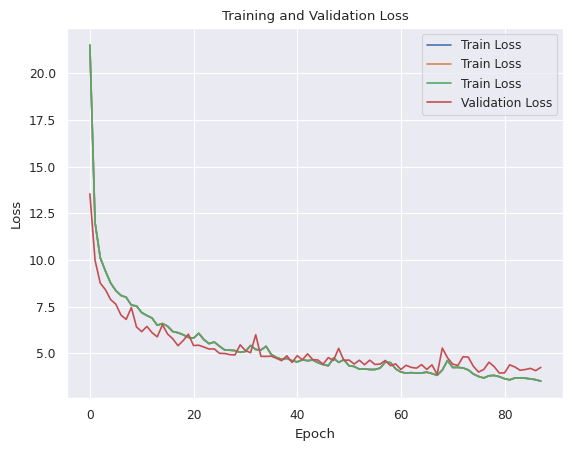

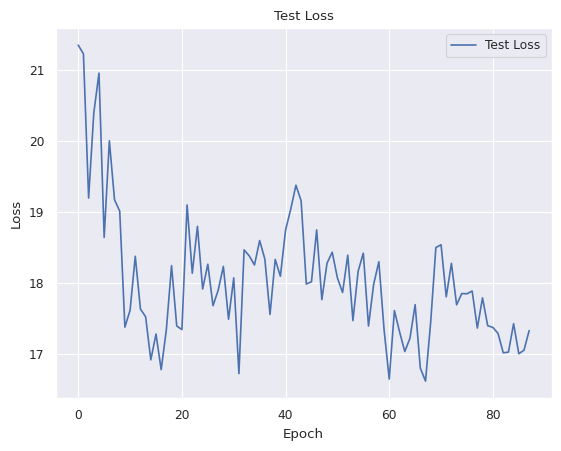

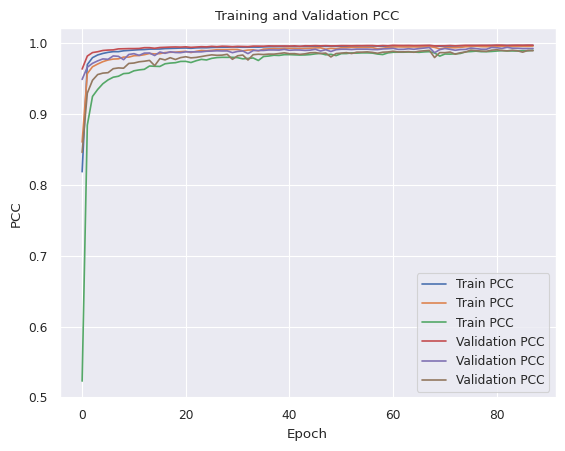

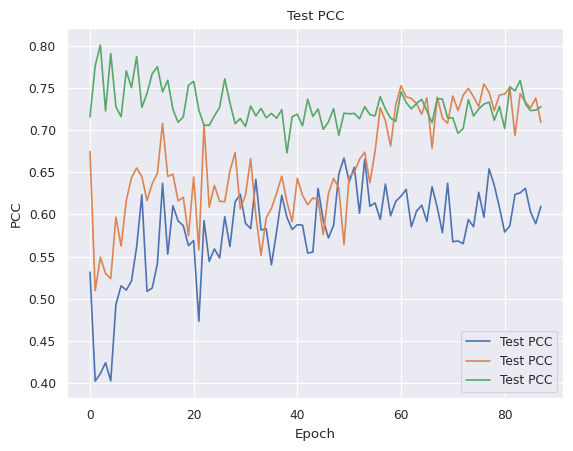

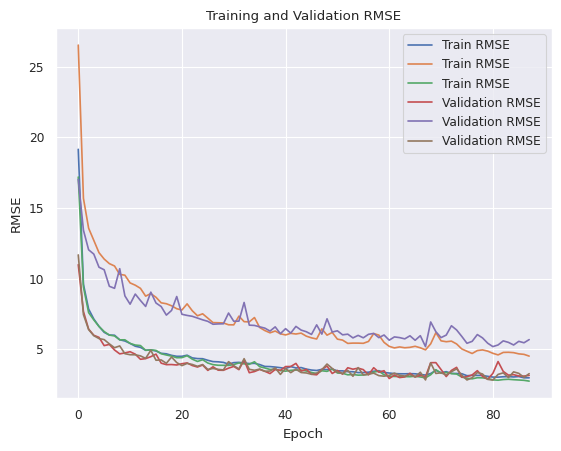

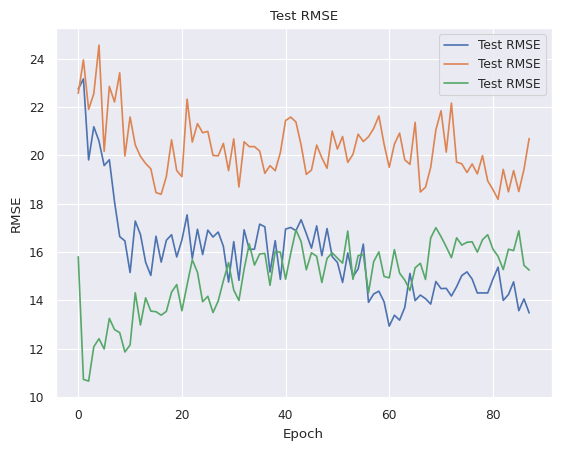

In [58]:
# prompt: plot necessary values

import matplotlib.pyplot as plt

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss')
plt.legend()
plt.show()


plt.plot(train_pccs, label='Train PCC')
plt.plot(val_pccs, label='Validation PCC')
plt.xlabel('Epoch')
plt.ylabel('PCC')
plt.title('Training and Validation PCC')
plt.legend()
plt.show()

plt.plot(test_pccs, label='Test PCC')
plt.xlabel('Epoch')
plt.ylabel('PCC')
plt.title('Test PCC')
plt.legend()
plt.show()

plt.plot(train_rmses, label='Train RMSE')
plt.plot(val_rmses, label='Validation RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Training and Validation RMSE')
plt.legend()
plt.show()

plt.plot(test_rmses, label='Test RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Test RMSE')
plt.legend()
plt.show()